In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd

import sys
import librosa
import numpy as np
import os
import glob
import json

import torch
from text import text_to_sequence, cmudict
from text.symbols import symbols
import commons
import attentions
import modules
import models
import utils



DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [15]:
# If you are using your own trained model
model_dir = "/media/caijb/data_drive/glowtts/logs/base/"
hps = utils.get_hparams_from_dir(model_dir)
checkpoint_path = utils.latest_checkpoint_path(model_dir)

# If you are using a provided pretrained model
# hps = utils.get_hparams_from_file("./configs/any_config_file.json")
# checkpoint_path = "/path/to/pretrained_model"

model = models.FlowGenerator(
    len(symbols) + getattr(hps.data, "add_blank", False),
    out_channels=hps.data.n_mel_channels,
    **hps.model).to("cuda")

utils.load_checkpoint(checkpoint_path, model)
model.decoder.store_inverse() # do not calcuate jacobians for fast decoding
_ = model.eval()

cmu_dict = cmudict.CMUDict(hps.data.cmudict_path)

# normalizing & type casting
def normalize_audio(x, max_wav_value=hps.data.max_wav_value):
    return np.clip((x / np.abs(x).max()) * max_wav_value, -32768, 32767).astype("int32")

/media/caijb/data_drive/glowtts/logs/base/G_204.pth
INFO:root:Loaded checkpoint '/media/caijb/data_drive/glowtts/logs/base/G_204.pth' (iteration 204)


In [16]:
tst_stn = "This is testing sentence that is not used in training." 

if getattr(hps.data, "add_blank", False):
    text_norm = text_to_sequence(tst_stn.strip(), ['english_cleaners'], cmu_dict)
    text_norm = commons.intersperse(text_norm, len(symbols))
else: # If not using "add_blank" option during training, adding spaces at the beginning and the end of utterance improves quality
    tst_stn = " " + tst_stn.strip() + " "
    text_norm = text_to_sequence(tst_stn.strip(), ['english_cleaners'], cmu_dict)
print(text_norm)
sequence = np.array(text_norm)[None, :]
print("".join([symbols[c] if c < len(symbols) else "<BNK>" for c in sequence[0]]))
x_tst = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()
x_tst_lengths = torch.tensor([x_tst.shape[1]]).cuda()

[147, 90, 147, 108, 147, 130, 147, 10, 147, 108, 147, 145, 147, 10, 147, 132, 147, 93, 147, 130, 147, 132, 147, 107, 147, 119, 147, 10, 147, 130, 147, 93, 147, 118, 147, 132, 147, 72, 147, 118, 147, 130, 147, 10, 147, 90, 147, 69, 147, 132, 147, 10, 147, 108, 147, 145, 147, 10, 147, 118, 147, 65, 147, 132, 147, 10, 147, 144, 147, 140, 147, 145, 147, 89, 147, 10, 147, 107, 147, 118, 147, 10, 147, 56, 147, 54, 147, 37, 147, 45, 147, 50, 147, 45, 147, 50, 147, 43, 147, 7, 147]
<BNK>@DH<BNK>@IH1<BNK>@S<BNK> <BNK>@IH1<BNK>@Z<BNK> <BNK>@T<BNK>@EH1<BNK>@S<BNK>@T<BNK>@IH0<BNK>@NG<BNK> <BNK>@S<BNK>@EH1<BNK>@N<BNK>@T<BNK>@AH0<BNK>@N<BNK>@S<BNK> <BNK>@DH<BNK>@AE1<BNK>@T<BNK> <BNK>@IH1<BNK>@Z<BNK> <BNK>@N<BNK>@AA1<BNK>@T<BNK> <BNK>@Y<BNK>@UW1<BNK>@Z<BNK>@D<BNK> <BNK>@IH0<BNK>@N<BNK> <BNK>t<BNK>r<BNK>a<BNK>i<BNK>n<BNK>i<BNK>n<BNK>g<BNK>.<BNK>


/home/caijb/Desktop/glow-tts/models.py:322: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_lengths = (y_lengths // self.n_sqz) * self.n_sqz


DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved


DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved


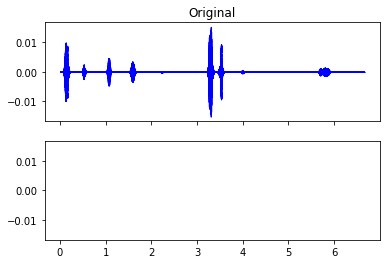

In [20]:
with torch.no_grad():
    noise_scale = .667
    length_scale = 1.0
    (y_gen_tst, *_), *_, (attn_gen, *_) = model(x_tst, x_tst_lengths, gen=True, noise_scale=noise_scale, length_scale=length_scale)
    y_gen=y_gen_tst.cpu().numpy()
    y_gen=librosa.feature.inverse.mel_to_stft(y_gen)
    audio=librosa.griffinlim(y_gen,n_iter=60)

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
import librosa.display as dp
dp.waveshow(audio, sr=hps.data.sampling_rate, color='b', ax=ax[0])
ax[0].set(title='Original', xlabel=None)
ax[0].label_outer()
ipd.Audio(audio, rate=hps.data.sampling_rate)